# ToDo

- Instead of doing 4 searches over 100.000 models each, how about you dimwit just search them once and then filter that database? Jup :)

In [1]:
from __future__ import annotations

import itertools as it
import math
from pathlib import Path
from typing import Any, Dict, Callable, cast
import textwrap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.utils import io
from modelbase.ode import Simulator
from pebble import concurrent
from tqdm.notebook import tqdm
from utils import get_model
from concurrent.futures import ProcessPoolExecutor

from utils import Figure, Axis

IMG_PATH = Path("results") / "img"


def get_new_y0(s):
    return dict(s.get_results_df().iloc[-1])


def generate_pars(seed: int, scale: float, pars_to_change: list[str]) -> dict[str, float]:
    gen = np.random.default_rng(seed)
    factors = gen.lognormal(mean=0, sigma=scale, size=len(pars_to_change))
    m = get_model(initial_pfd=700)
    new_pars: dict[str, float] = {}
    for i, par in enumerate(pars_to_change):
        old_val = m.get_parameter(par)
        new_pars[par] = old_val * factors[i]
    return new_pars


def find_steady_state_with_matching_fluxes(
    new_pars: dict[str, float],
    rtol: float,
    **kwargs,
) -> tuple[pd.Series, pd.Series, dict[str, float]] | None:
    fluxes_to_compare: list[str] = kwargs["fluxes_to_compare"]
    v_reference: pd.DataFrame = kwargs["v_reference"]
    y0 = kwargs["y0"]
    try:
        s = Simulator(m)
        s.initialise(y0)
        with io.capture_output():
            _, y_ss_raw = s.simulate_to_steady_state()
        if y_ss_raw is None:
            return None
        y_ss = m.get_full_concentration_dict(y_ss_raw)
        v_ss = m.get_fluxes_dict(y_ss)
        to_compare = [abs(1 - float(v_ss[i]) / v_reference[i]) for i in fluxes_to_compare]
        if all(i > rtol for i in to_compare):
            return None
        concs = pd.DataFrame(y_ss, dtype=float).loc[0]
        fluxes = pd.DataFrame(v_ss, dtype=float).loc[0]
        return concs, fluxes, new_pars
    except Exception as e:
        print("find_steady_state_with_matching_fluxes: Exception: ", e)
        return None


def pam_analysis(
    y0: dict[str, float],
    pars: dict[str, float],
    t_relax: float,
    t_pulse: float,
    pfd_dark: float,
    pfd_illumination: float,
    pfd_pulse: float,
    integrator_kwargs: Dict[str, Any] | None = None,
) -> tuple[pd.DataFrame | None, pd.DataFrame | None]:
    s = Simulator(get_model(700))
    s.initialise(y0)
    s.update_parameters(pars)
    s.update_parameter("kcyc", 0.0)  # why again?
    if integrator_kwargs is None:
        integrator_kwargs = {}
    t = it.accumulate(it.chain.from_iterable((t_relax, t_pulse) for i in range(32)))
    pfds = list(
        [pfd_dark, pfd_pulse] * 2
        + [pfd_illumination, pfd_pulse] * 10
        + [pfd_dark, pfd_pulse] * 8
    )

    with io.capture_output():
        for t_end, pfd in zip(t, pfds):
            s.update_parameter("pfd", pfd)
            s.simulate(t_end, **integrator_kwargs)
    return cast(pd.DataFrame, s.get_full_results_df()), cast(
        pd.DataFrame, s.get_fluxes_df()
    )


def find_steady_state_with_matching_fluorescence(
    new_pars: dict[str, float],
    rtol: float,
    **kwargs,
) -> tuple[pd.Series, pd.Series, dict[str, float]] | None:
    fluo_reference: pd.Series[float] = kwargs["fluo_reference"]
    y0 = kwargs["y0"]
    try:
        pam_c_test, _ = pam_analysis(
            y0,
            new_pars,
            t_relax=120,
            t_pulse=0.8,
            pfd_dark=50,
            pfd_illumination=1000,
            pfd_pulse=5000,
        )
        if pam_c_test is None:
            return None
        fluo_test = (
            pd.concat(
                [
                    pam_c_test["Fluo"],
                    pam_c_test["Fluo"].reindex(index=fluo_reference.index),
                ]
            )
            .sort_index()
            .interpolate()[fluo_reference.index]
        )
        error = ((fluo_test - fluo_reference) / fluo_reference).abs().mean()
        if error > rtol:
            return None
        return find_steady_state_with_matching_fluxes(
            new_pars,
            rtol,
            **{
                "fluxes_to_compare": kwargs.get("fluxes_to_compare", []),
                "v_reference": kwargs.get("v_reference", []),
                "y0": y0,
            },
        )
    except Exception as e:
        print("find_steady_state_with_matching_fluorescence: Exception:", e)
        return None


def batch(
    res: list,
    initial_seed: int,
    start: int,
    n: int,
    pars_to_change: list[str],
    scale: float,
    rtol: float,
    search_fn: Callable[
        [dict[str, float], float], tuple[pd.Series, pd.Series, dict[str, float]] | None
    ],
    fn_timeout: int,
    **kwargs,
) -> None:
    fn = concurrent.process(
        lambda seed: search_fn(
            generate_pars(seed, scale, pars_to_change),
            rtol,
            **kwargs,
        ),
        timeout=fn_timeout,
    )
    futures = [fn(initial_seed + seed) for seed in range(start, start + n)]

    for i in futures:
        try:
            r = i.result()
            if r is not None:
                res.append(r)
        except:
            pass


def search(
    p_file: Path,
    c_file: Path,
    v_file: Path,
    n_samples: int,
    batch_size: int,
    scale: float,
    rtol: float,
    search_fn: Any,
    fn_timeout: int,
    initial_seed: int = 0,
    **kwargs,
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    if p_file.exists() and c_file.exists() and v_file.exists():
        print("Loading existing")
        pars: pd.DataFrame = pd.read_json(p_file)  # type: ignore
        concs: pd.DataFrame = pd.read_json(c_file)  # type: ignore
        fluxes: pd.DataFrame = pd.read_json(v_file)  # type: ignore
        print(len(concs))
    else:
        print("Generating new")
        res = []
        for start in tqdm(range(0, n_samples, batch_size)):
            batch(
                res,
                initial_seed,
                start,
                batch_size,
                pars_to_change,
                scale,
                rtol,
                search_fn,
                fn_timeout,
                **kwargs,
            )
        if len(res) == 0:
            raise ValueError("No results found")
        else:
            print(len(res))
        concs = pd.DataFrame([i[0] for i in res], index=range(len(res)), dtype=float)
        fluxes = pd.DataFrame([i[1] for i in res], index=range(len(res)), dtype=float)
        pars = pd.DataFrame([i[2] for i in res], dtype=float).drop(columns="pfd")
        pars.to_json(p_file)
        concs.to_json(c_file)
        fluxes.to_json(v_file)
    return pars, concs, fluxes


def plot_par_cv(
    pars: pd.DataFrame,
    p_reference: pd.Series,
    figsize: tuple[float, float] = (20, 8),
    ylim: tuple[float, float] | None = None,
    wrap_xlabels: bool = False,
) -> tuple[Figure, Axis]:
    rel = pars / p_reference
    # rel.std().sort_values().index
    ax: Axis = rel[rel.max().sort_values().index].plot(
        kind="box",
        figsize=figsize,
        ylabel="Parameters relative to reference",
        title="Parameters",
    )  # type: ignore
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)  # type: ignore
    ax.set_ylim(ylim)
    ax.grid()
    ax.set_title(ax.get_title(), fontsize=20)
    ax.set_xticklabels(
        [
            textwrap.fill(i.get_text(), width=20, break_long_words=False)
            if wrap_xlabels
            else i
            for i in ax.get_xticklabels()
        ]
    )
    ax.tick_params(labelsize=14)
    ax.set_ylabel(ax.get_ylabel(), fontsize=14)
    return ax.get_figure(), ax


def plot_flux_cv(
    fluxes: pd.DataFrame,
    v_reference: pd.Series,
    figsize: tuple[float, float] = (20, 8),
    ylim: tuple[float, float] | None = (-0.5, 0.5),
    wrap_xlabels: bool = False,
) -> tuple[Figure, Axis]:
    rel = fluxes / v_reference

    # rel.std().sort_values().index
    ax: Axis = (rel)[rel.max().sort_values().index].plot(
        kind="box",
        figsize=figsize,
        ylabel="Flux relative to reference",
        title="Fluxes",
    )  # type: ignore
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)  # type: ignore
    ax.set_ylim(ylim)
    ax.grid()
    ax.set_title(ax.get_title(), fontsize=20)

    xlabels = [
        long_rxn_names.get(i.get_text(), i.get_text()) for i in ax.get_xticklabels()
    ]
    if wrap_xlabels:
        xlabels = [textwrap.fill(i, width=20, break_long_words=False) for i in xlabels]
    ax.set_xticklabels(xlabels)
    ax.tick_params(labelsize=14)
    ax.set_ylabel(ax.get_ylabel(), fontsize=14)
    return ax.get_figure(), ax


def plot_conc_cv(
    concs: pd.DataFrame,
    c_reference: pd.Series,
    figsize: tuple[float, float] = (20, 8),
    ylim: tuple[float, float] | None = None,
    wrap_xlabels: bool = False,
) -> tuple[Figure, Axis]:
    rel = concs / c_reference  # c.mean()
    # rel.std().sort_values().index
    ax: Axis = rel[rel.max().sort_values().index].plot(
        kind="box",
        figsize=figsize,
        ylabel="Concentrations relative to reference",
        title="Concentrations",
    )  # type: ignore
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)  # type: ignore
    ax.set_ylim(ylim)
    ax.grid()
    ax.set_title(ax.get_title(), fontsize=20)
    ax.set_xticklabels(
        [
            textwrap.fill(i.get_text(), width=20, break_long_words=False)
            if wrap_xlabels
            else i
            for i in ax.get_xticklabels()
        ]
    )
    ax.tick_params(labelsize=14)
    ax.set_ylabel(ax.get_ylabel(), fontsize=14)
    return ax.get_figure(), ax


long_rxn_names = {
    # PETC
    "vPS2": "PS2",  # photosystem II
    "vPS1": "PS1",  # photosystem I
    "vPTOX": "plastid terminal oxidase",
    "vNDH": "NAD(P)H dehydrogenase-like complex",
    "vB6f": "Cytochrome b6f complex",
    "vCyc": "cyclic electron flow",
    "vFNR": "Ferredoxin-NADP reductase",
    # "vLeak": "proton leak",
    "vSt12": "PSI-PSII state transition",
    "vSt21": "PSII-PSI state transition",
    "vATPsynthase": "ATP synthase",
    "vDeepox": "Violaxanthin de-epoxidase",
    "vEpox": "Zeaxanthin epoxidase",
    "vLhcprotonation": "LHC protonation",
    "vLhcdeprotonation": "LHC deprotonation",
    # CBB
    "vRuBisCO": "RuBisCO",
    "vPGA_kinase": "PGA kinase",  # "phosphoglycerate kinase",
    "vBPGA_dehydrogenase": "GAPDH",
    "vTPI": "TPI ",
    "vAldolase": "aldolase (FBP)",
    "vFBPase": "FBPase",
    "vF6P_Transketolase": "TK (F6P)",
    "v8": "aldolase (SBP)",
    "v9": "SBPase",
    "v10": "TK (S7P)",
    "v11": "R5P isomerase",
    "v12": "RPE",
    "v13": "PRK",
    "vG6P_isomerase": "G6P isomerase",
    "vPhosphoglucomutase": "",
    # "vpga": "Efflux (PGA)",
    # "vgap": "Efflux (GAP)",
    # "vdhap": "Efflux (DHAP)",
    # "vStarch": "",
    # Mehler
    "vFdred": "Ferredoxin reductase",
    "vAscorbate": "ascorbate peroxidase",
    "vMDAreduct": "monodehydroascorbate reductase",
    "vDHAR": "dehydroascorbate reductase",
    "v3ASC": "L-ascorbate peroxidase",
    "vGR": "glutathione reductase",
    "vMehler": "mehler",
    # "vEX_ATP": "",
    # "vEX_NADPH": ""1,
    # "vFdTrReductase": "",
    # "vE_activation": "",
    # "vE_inactivation": "",
}

In [2]:
y0_700 = {
    "PQ": 7.866063303361211,
    "PC": 3.567990538626763,
    "Fd": 1.8343886661603268,
    "ATP": 1.692562968894315,
    "NADPH": 0.6764550907522385,
    "H": 0.0028140803204291277,
    "LHC": 0.6920727587203929,
    "Psbs": 0.9255579685757311,
    "Vx": 0.8551256174243594,
    "PGA": 1.83495181479737,
    "BPGA": 0.0011228686476791793,
    "GAP": 0.014142514007116238,
    "DHAP": 0.31113522531928234,
    "FBP": 0.03124164892321713,
    "F6P": 1.4106682364393035,
    "G6P": 3.244536942658096,
    "G1P": 0.18818314264511155,
    "SBP": 0.12040681805328911,
    "S7P": 0.44158431656753216,
    "E4P": 0.029768614132807878,
    "X5P": 0.05629530041013304,
    "R5P": 0.09429462457154986,
    "RUBP": 0.6178444450420166,
    "RU5P": 0.037717849213228793,
    "MDA": 9.206405078639427e-06,
    "H2O2": 5.446828050204499e-06,
    "DHA": 2.1066589845211926e-08,
    "GSSG": 1.0220142889592514e-08,
    "TR_ox": 0.7067168387568679,
    "E_inactive": 1.52561833083179,
}

In [3]:
m = get_model(700)
s = Simulator(m)
s.initialise(y0_700)
_, y_ss_raw = s.simulate_to_steady_state()
y_ss = m.get_full_concentration_dict(y_ss_raw)  # type: ignore
v_ss = m.get_fluxes_dict(y_ss)

c_reference: pd.Series[float] = (
    pd.Series({k: float(v) for k, v in y_ss.items()}, dtype=float)
    .sort_values()
    .drop("time")
)
v_reference: pd.Series[float] = pd.Series(
    {k: float(v) for k, v in v_ss.items()}, dtype=float
).sort_values()
reference_flux = float(v_ss["vRuBisCO"])

pars_by_rxn = {
    "vPS2": ["k2"],
    "vPTOX": ["kPTOX"],
    "vNDH": ["kNDH"],
    "vB6f": ["kCytb6f"],
    "vCyc": ["kcyc"],
    "vFNR": ["KM_FNR_F", "KM_FNR_N", "EFNR", "kcatFNR", "Keq_FNR", "convf"],
    "vLeak": ["kLeak"],
    "vSt12": ["kStt7"],
    "vSt21": ["kPph1"],
    "vATPsynthase": ["kATPsynth"],
    "vDeepox": ["kDeepoxV"],
    "vEpox": ["kEpoxZ"],
    "vLhcprotonation": ["kProtonationL"],
    "vLhcdeprotonation": ["kDeprotonation"],
    "vRuBisCO": ["Km1", "V1_base"],
    "vFBPase": ["Km6", "V6_base"],
    "v9": ["Km9", "V9_base"],
    "v13": ["Km131", "V13_base"],
    "vStarch": ["Kmst1", "Kmst2", "Vst_base"],
    "vpga": ["Vmax_efflux"],  # also vgap, vdhap
    "vFdred": ["kFdred"],
    "vAscorbate": ["kf1"],
    "vMDAreduct": ["kcatMDAR", "KmMDAR_NADPH", "KmMDAR_MDA"],
    "vMehler": ["kMehler"],
    "vGR": ["kcat_GR", "KmNADPH", "KmGSSG"],
    "vDHAR": ["kcat_DHAR", "KmDHA", "KmGSH"],
    "v3ASC": ["k3"],
    "vEX_ATP": ["k_ex_atp"],
    "vEX_NADPH": ["k_ex_nadph"],
    "vFdTrReductase": ["k_fd_tr_reductase"],
    "vE_activation": ["k_e_cbb_activation"],
    "vE_inactivation": ["k_e_cbb_relaxation"],
}

pars_to_change = [j for i in pars_by_rxn.values() for j in i]

p_reference: pd.Series[float] = pd.Series({i: m.parameters[i] for i in pars_to_change})

In [4]:
batch_size = 50
scale = 1  # 0.5
rtol = 0.01
n_samples = 100_000

result_dir = Path("results") / "ensemble"

# 10_000: 70 min per search
# 100_000: 724 min per search

# v1: Only keep rubisco fixed

In [5]:
pars, concs, fluxes = search(
    result_dir / "p1.json",
    result_dir / "c1.json",
    result_dir / "v1.json",
    n_samples,
    batch_size,
    scale,
    rtol,
    find_steady_state_with_matching_fluxes,
    fn_timeout=30,
    **{"fluxes_to_compare": ["vRuBisCO"], "v_reference": v_reference, "y0": y0_700},
)

Loading existing
321


In [6]:
# diff = (fluxes[cbb_reactions] / v_reference[cbb_reactions])
# span = diff.max() - diff.min()

# fig, ax = plt.subplots(figsize=(15, 5))
# (span * 100).sort_values().plot(kind="bar", ax=ax)
# ax.set_ylim(0, 50)
# ax.set_yticks(np.arange(0, 60, 10))
# ax.grid()
# ax.set_ylabel("Scale / %")
# ax.set_xticklabels([long_rxn_names.get(i.get_text(), i.get_text()) for i in ax.get_xticklabels()])
# plt.show()

In [7]:
fig, ax = plot_par_cv(pars, p_reference, figsize=(18, 10))
plt.savefig(IMG_PATH / "part0-ensemble-pars.png", bbox_inches="tight", dpi=200)

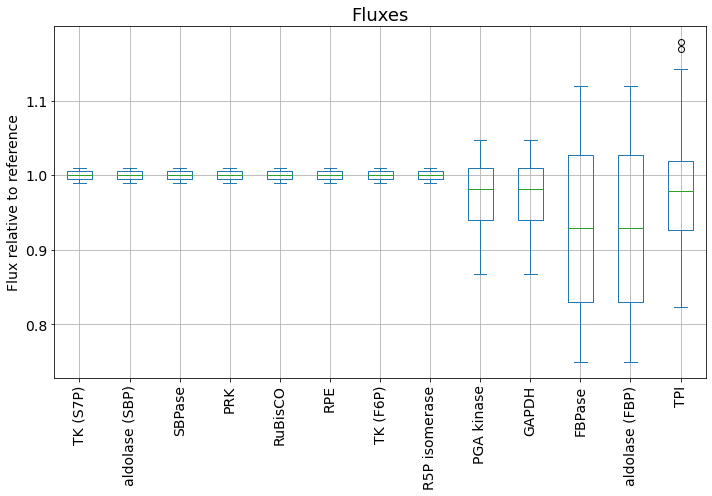

In [8]:
cbb_reactions = [
    "vRuBisCO",
    "vPGA_kinase",
    "vBPGA_dehydrogenase",
    "vTPI",
    "vAldolase",
    "vFBPase",
    "vF6P_Transketolase",
    "v8",
    "v9",
    "v10",
    "v11",
    "v12",
    "v13",
    # "vG6P_isomerase",
    # "vPhosphoglucomutase",
    # "vpga",
    # "vgap",
    # "vdhap",
    # "vStarch",
]

fig, ax = plot_flux_cv(
    fluxes[cbb_reactions],
    v_reference[cbb_reactions],
    figsize=(10, 7),
    ylim=None,
    wrap_xlabels=True,
)
ax.set_title(ax.get_title(), fontsize=18)
fig.tight_layout()
plt.savefig(IMG_PATH / "part0-ensemble-flux-selection.png", bbox_inches="tight", dpi=200)

In [12]:
fig, ax = plot_flux_cv(fluxes, v_reference, figsize=(16, 10), ylim=(0, 100))
fig.tight_layout()
plt.savefig(IMG_PATH / "part0-ensemble-flux.png", bbox_inches="tight", dpi=200)

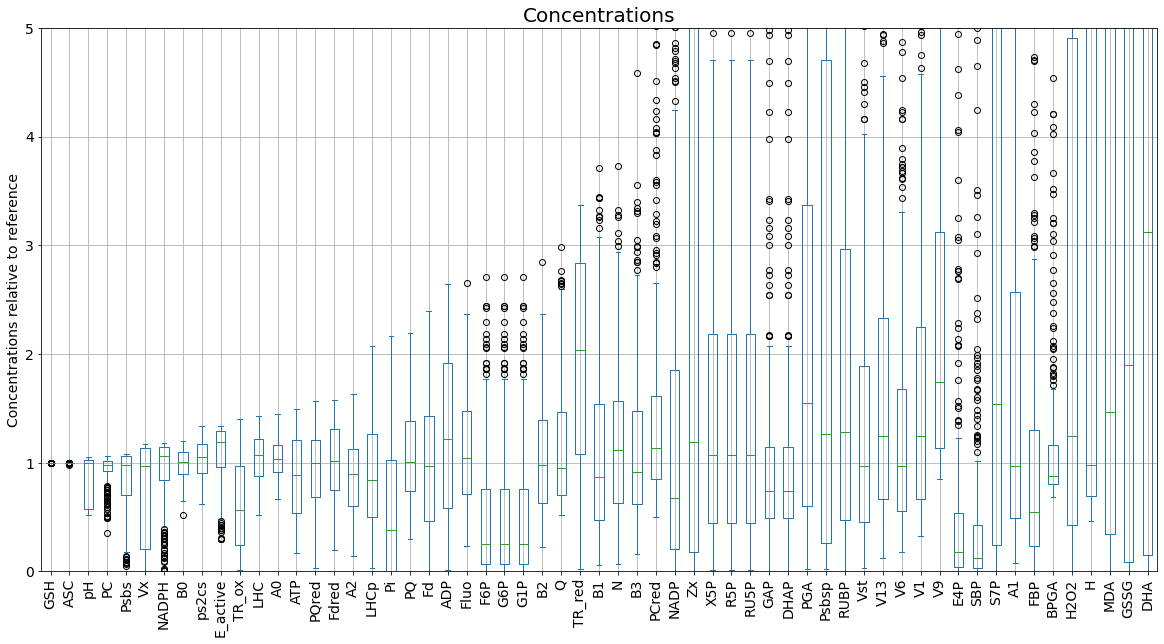

In [92]:
to_drop = [
    "Keq_ATPsynthase",
    "Keq_B6f",
    "PQ_redoxstate",
    "Fd_redoxstate",
    "PC_redoxstate",
    "NADP_redoxstate",
    "ATP_norm",
    "E_inactive",
]

fig, ax = plot_conc_cv(
    concs.drop(columns=["time"] + to_drop),
    c_reference.drop(index=to_drop),
    figsize=(20, 10),
    ylim=(0, 5),
)
plt.savefig(IMG_PATH / "part0-ensemble-concs.png", bbox_inches="tight", dpi=200)

# v2: keep photosystems fixed

In [7]:
pars, concs, fluxes = search(
    result_dir / "p2.json",
    result_dir / "c2.json",
    result_dir / "v2.json",
    n_samples,
    batch_size,
    scale,
    rtol,
    find_steady_state_with_matching_fluxes,
    fn_timeout=30,
    **{
        "fluxes_to_compare": ["vPS2", "vPS1"],
        "v_reference": v_reference,
        "y0": y0_700,
    },
)

Loading existing
57


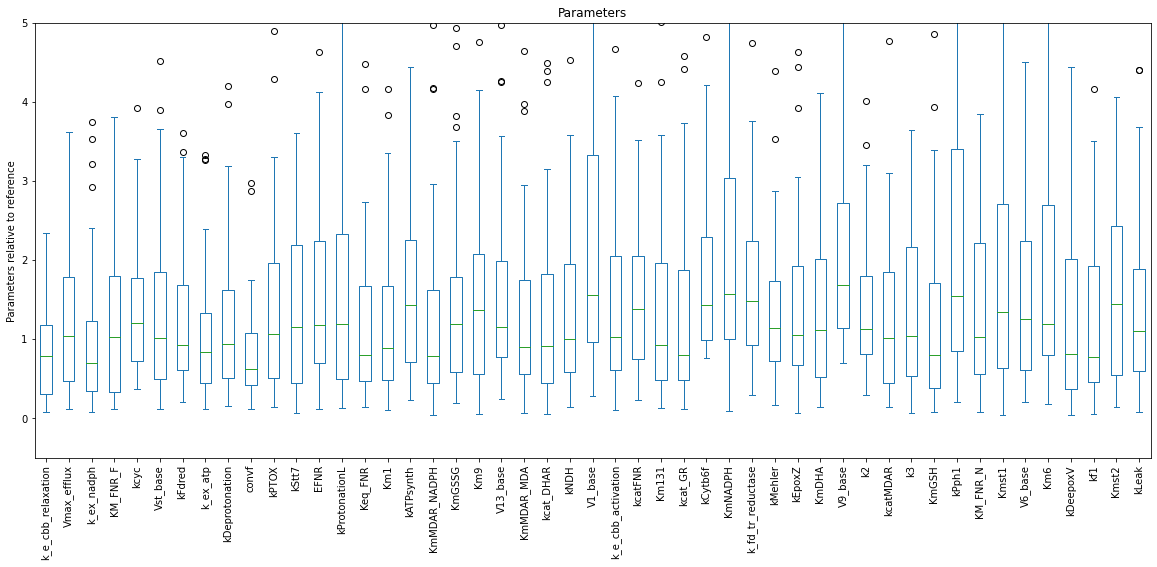

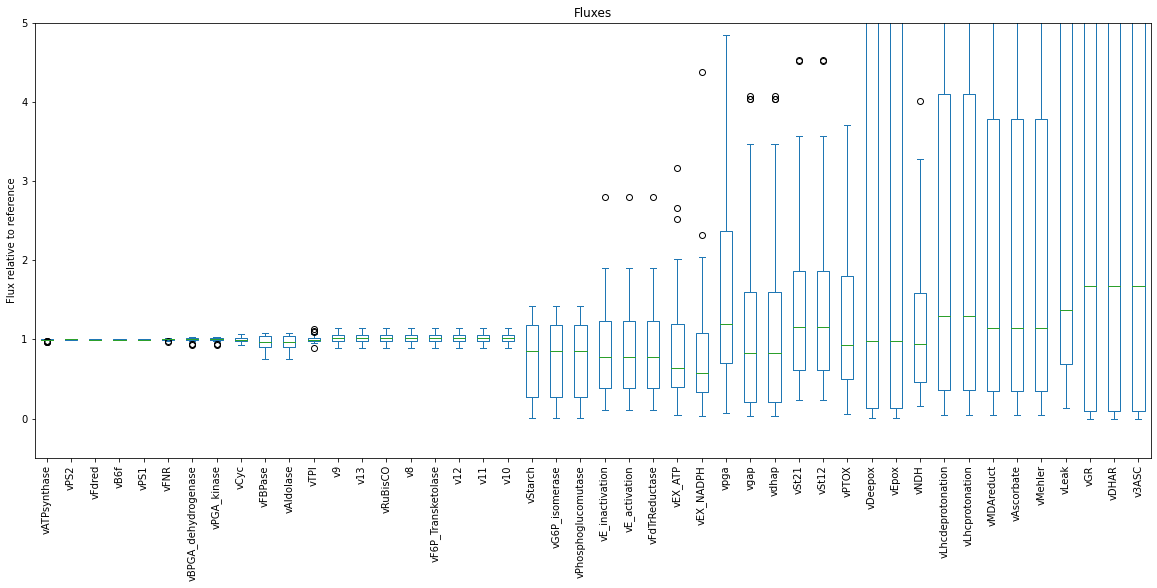

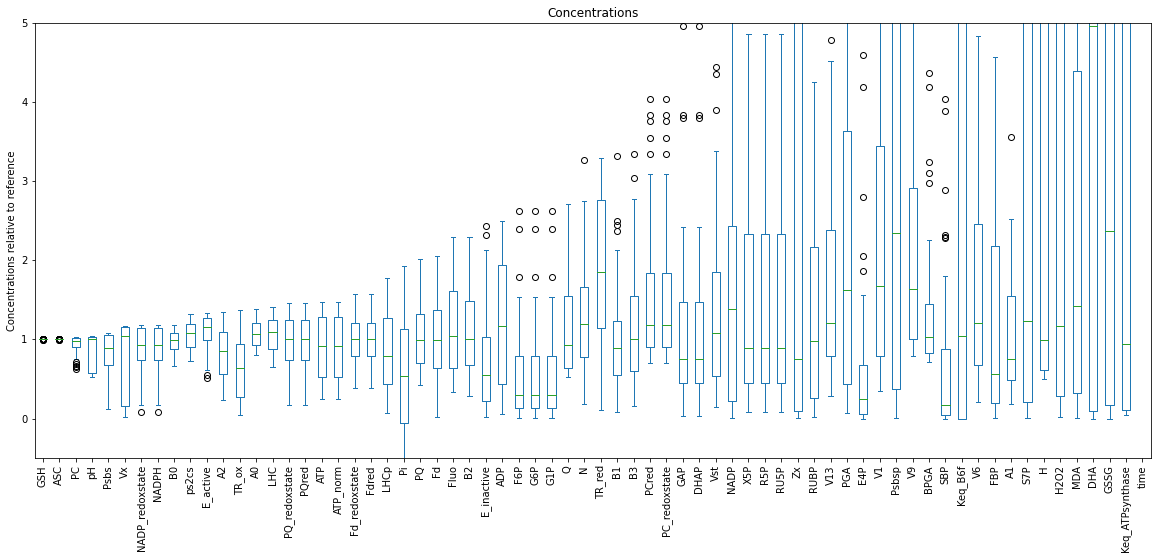

In [8]:
plot_par_cv(pars, p_reference)
plot_flux_cv(fluxes, v_reference)
plot_conc_cv(concs, c_reference)

# v3: keep ps and rubisco fixed

In [37]:
pars, concs, fluxes = search(
    result_dir / "p3.json",
    result_dir / "c3.json",
    result_dir / "v3.json",
    n_samples,
    batch_size,
    scale,
    rtol,
    find_steady_state_with_matching_fluxes,
    fn_timeout=30,
    **{
        "fluxes_to_compare": ["vRuBisCO", "vPS2", "vPS1"],
        "v_reference": v_reference,
        "y0": y0_700,
    },
)

Loading existing
10


In [ ]:
pam_c, pam_v = pam_analysis(
    y0_700,
    {},
    t_relax=120,
    t_pulse=0.8,
    pfd_dark=50,
    pfd_illumination=1000,
    pfd_pulse=5000,
)

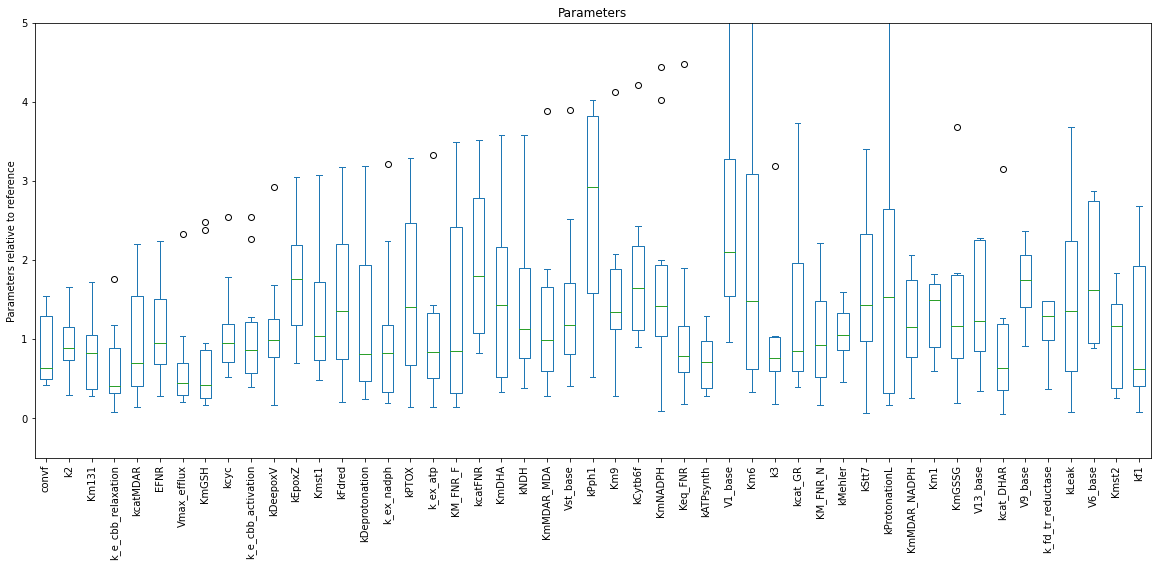

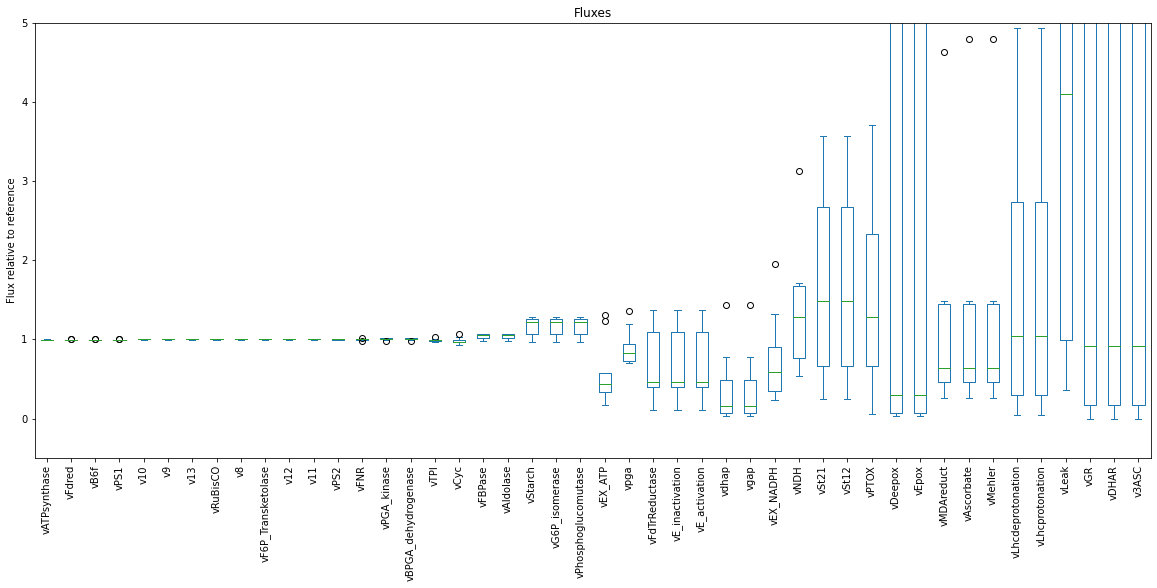

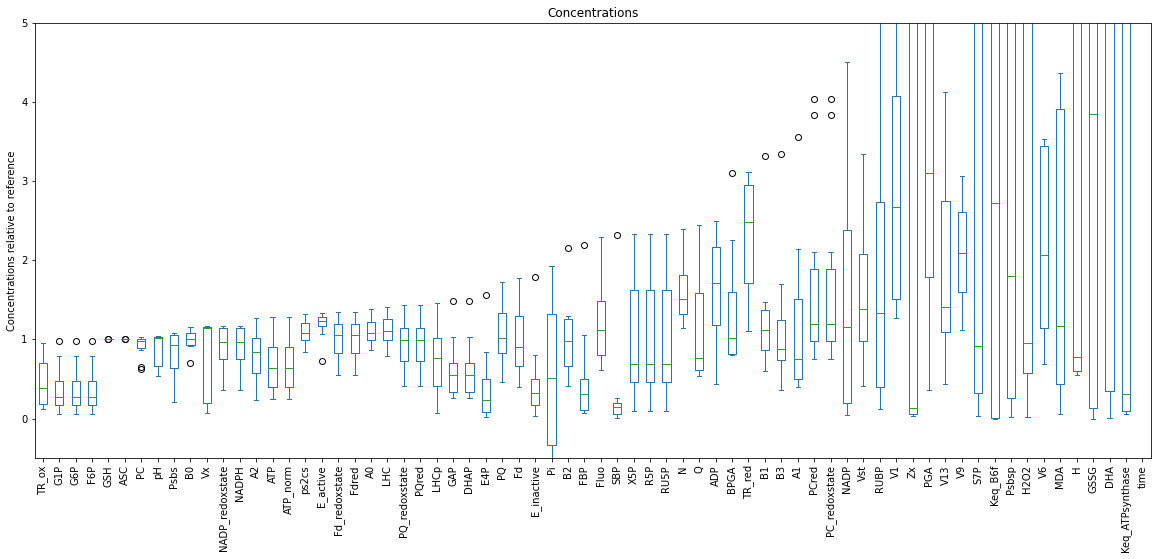

In [38]:
plot_par_cv(pars, p_reference)
plot_flux_cv(fluxes, v_reference)
plot_conc_cv(concs, c_reference)

In [42]:
c_reference["pH"]

6.152723502274394

In [40]:
concs["pH"]

0    3.331567
1    3.543002
2    6.376946
3    3.542836
4    6.248939
5    6.273125
6    5.712977
7    6.383380
8    6.410835
9    6.373857
Name: pH, dtype: float64

In [15]:
from functools import partial

fn = partial(
    pam_analysis,
    t_relax=120,
    t_pulse=0.8,
    pfd_dark=50,
    pfd_illumination=1000,
    pfd_pulse=5000,
)

In [16]:
fn = lambda y0, p: pam_analysis(
    y0,
    p,
    t_relax=120,
    t_pulse=0.8,
    pfd_dark=50,
    pfd_illumination=1000,
    pfd_pulse=5000,
)

pam_c_scan = []
pam_v_scan = []
with ProcessPoolExecutor() as p:
    for i, j in p.map(
        fn,
        concs.T.to_dict().values(),
        pars.T.to_dict().values(),
    ):
        pam_c_scan.append(i)
        pam_v_scan.append(j)

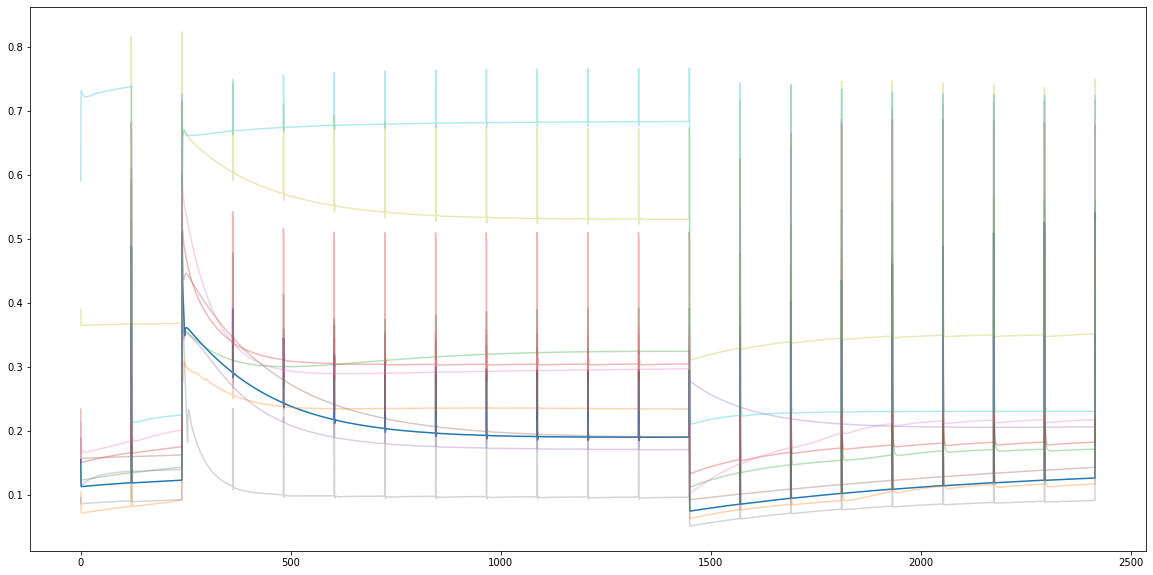

In [26]:
fig, ax = plt.subplots(figsize=(20, 10))
pam_c["Fluo"].plot(ax=ax)
for res in pam_c_scan:
    if res is None:
        continue
    res["Fluo"].plot(alpha=0.33, ax=ax)

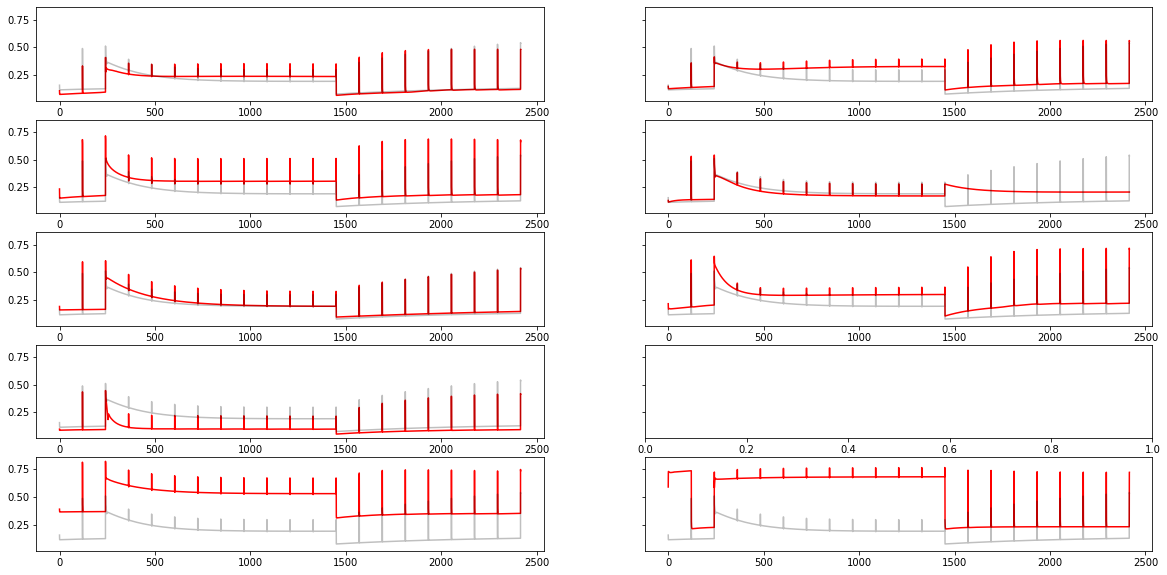

In [27]:
fig, axs = plt.subplots(math.ceil(len(pam_c_scan) / 2), 2, figsize=(20, 10), sharey=True)
for ax, res in zip(axs.flatten(), pam_c_scan):
    if res is None:
        continue
    res["Fluo"].plot(ax=ax, color="red")
    pam_c["Fluo"].plot(ax=ax, alpha=0.25, color="black")
plt.show()

# v4: keep pam fixed

- Didn't really work, need a better function to evaluate the "sameness" of these

In [32]:
# pars, concs, fluxes = search(
#     Path("p4.json"),
#     Path("c4.json"),
#     Path("v4.json"),
#     25_000,
#     batch_size,
#     scale,
#     0.50,
#     find_steady_state_with_matching_fluorescence,
#     fn_timeout=90,
#     **{
#         "fluo_reference": cast(pd.DataFrame, pam_c)["Fluo"],
#         "y0": y0_700,
#         "fluxes_to_compare": ["vRuBisCO"],
#         "v_reference": v_reference,
#     },
# )

# # 1000 = 30 min
# # 50_000m

In [33]:
# pam_c_scan = []
# pam_v_scan = []
# for p in pars.T.to_dict().values():
#     i, j = pam_analysis(
#         y0_700,
#         p,
#         t_relax=120,
#         t_pulse=0.8,
#         pfd_dark=50,
#         pfd_illumination=1000,
#         pfd_pulse=5000,
#     )
#     pam_c_scan.append(i)
#     pam_v_scan.append(j)

# ncols = math.ceil(len(pam_c_scan) / 2)

# fig, axs = plt.subplots(ncols, 2, figsize=(20, 3 * ncols), sharey=True)
# for ax, res in zip(axs.flatten(), pam_c_scan):
#     res["Fluo"].plot(ax=ax, color="red")
#     pam_c["Fluo"].plot(ax=ax, alpha=0.25, color="black")
# plt.show()